In [90]:
import numpy as np
from ase.io import read
import matplotlib.pyplot as plt 
from ase import Atoms
from ase.build import graphene
from ase.visualize import view
from ase.build import graphene_nanoribbon
from ase.neighborlist import neighbor_list
from ase.build import make_supercell

import abtem

# Structure


Cell([26.84, 17.21658502723464, 50.0])


(<Figure size 1000x500 with 1 Axes>, <Axes: xlabel='y [Å]', ylabel='x [Å]'>)

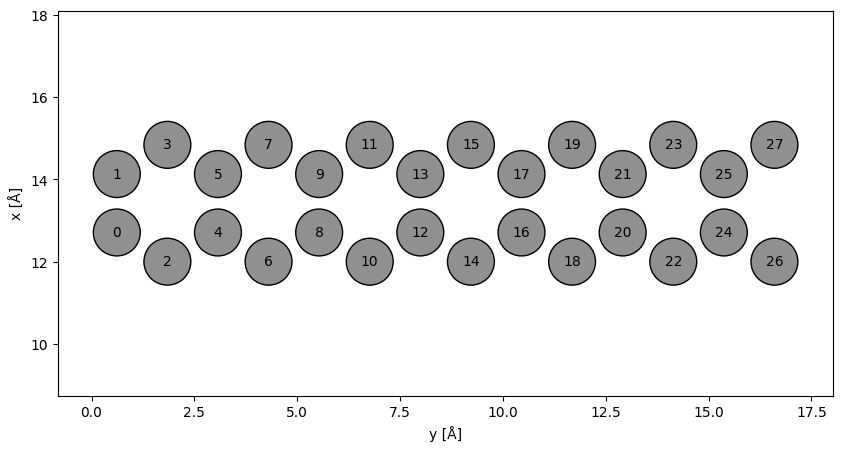

In [91]:
from functions import zgnr

Vpp_pi0=-2.7
Vpp_sigma0=0.48

# N = 6 # width
# L = 1 # length
# num_cells = 24

N = 2 # width
L = 1 # length
num_cells = 7

nL = 4
nR = 4

NR = zgnr(N,L)

NR.rotate(90, (1, 0, 0), rotate_cell=False)

NR.cell[1] = [0, NR.cell[2,2],0]
NR.cell[2] = [0,0,50.0]


# center in the cell
NR.center()

# sort atoms by x, then y (correct order)
xyz = NR.get_positions()
sorted_indices = np.lexsort((xyz[:, 0], xyz[:, 1]))  # no z sorting

NR = NR[sorted_indices]

# repeat
NR = NR.repeat((1,num_cells,1))
# atoms = atoms.repeat((1,5,1))


print(NR.cell)
#view(NR)
abtem.show_atoms(NR,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))

# Top flake

<Popen: returncode: None args: ['/home/oia/miniconda3/envs/abtem311/bin/pyth...>

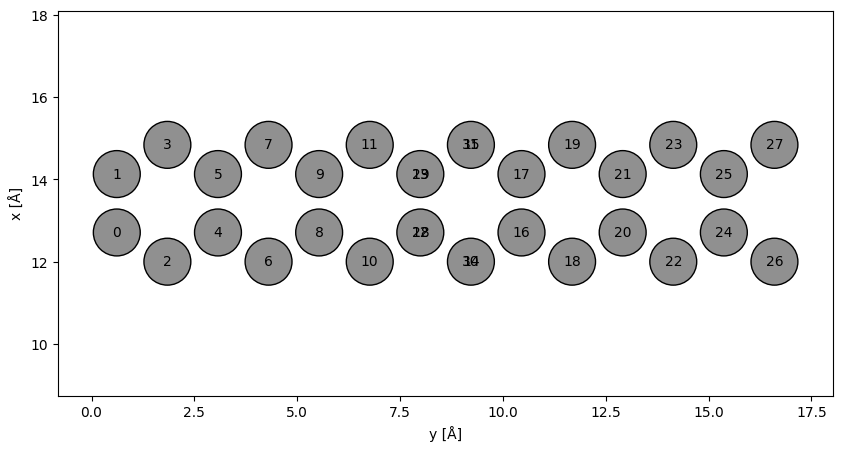

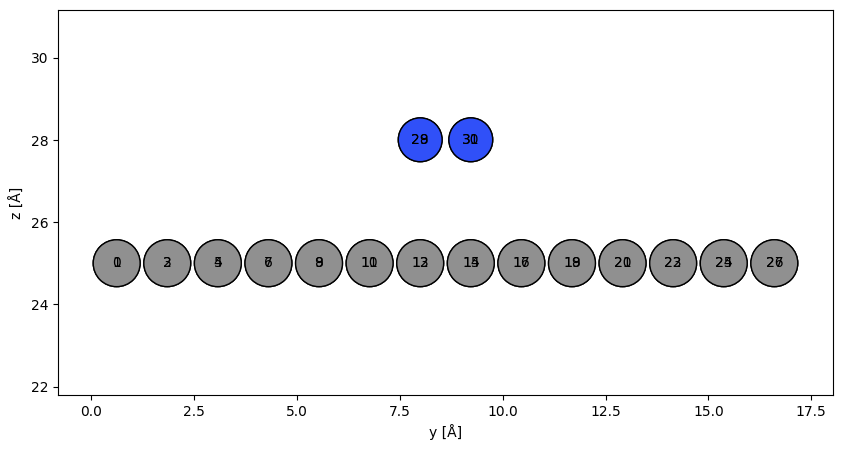

In [106]:
bottom = NR.copy()
top = NR.copy()

top.positions[:,2] += 3
num_del = nL*3

del top[0:num_del]
del top[len(top)-num_del::]
# change symbol to Nitrogen for identification
top.symbols = 'N'
atoms = bottom + top

abtem.show_atoms(atoms,plane='yx',numbering=True,merge = False,show_cell=False,figsize=(10,5))
abtem.show_atoms(atoms,plane='yz',numbering=True,merge = False,show_cell=False,figsize=(10,5))

view(atoms)

# Hamilton

In [107]:
def slater_koster(
    atoms,
    cutoff=6,
    d0=1.42,
    d_gg=3.35,
    r0=0.45,
    Vpp_pi0=-2.7,
    Vpp_sigma0=0.48,
    onsite=0.0,
    carbon_only=True
):
    """
    Compute Slater-Koster tight-binding Hamiltonian for graphene structures.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Atomic structure
    cutoff : float, optional
        Cutoff distance for interlayer hopping in Angstrom, default is 6
    d0 : float, optional
        In-plane C-C bond length in Angstrom, default is 1.42
    d_gg : float, optional
        Interlayer distance in Angstrom, default is 3.35
    r0 : float, optional
        Decay length in Angstrom, default is 0.45
    Vpp_pi0 : float, optional
        Pi-orbital hopping parameter in eV, default is -2.7
    Vpp_sigma0 : float, optional
        Sigma-orbital hopping parameter in eV, default is 0.48
    onsite : float, optional
        On-site energy in eV, default is 0.0
    carbon_only : bool, optional
        Whether to consider only carbon atoms, default is True
    
    Returns
    -------
    H : np.ndarray
        Total Hamiltonian matrix (H_TB + H_SK)
    H_TB : np.ndarray
        In-plane tight-binding Hamiltonian
    H_SK : np.ndarray
        Slater-Koster interlayer Hamiltonian
    H_pi : np.ndarray
        Pi-orbital contribution
    H_sigma : np.ndarray
        Sigma-orbital contribution
    """
    pos = atoms.positions
    N = len(atoms)

    H_TB = np.zeros((N, N))
    H_pi = np.zeros((N, N),)
    H_sigma = np.zeros((N, N))

    # onsite term (pi channel)
    for i in range(N):
        if not carbon_only and atoms[i].symbol == 'N':
            H_pi[i, i] = onsite #+ 1.5  # Nitrogen has higher onsite energy
        else:
            H_pi[i, i] = onsite

    # In plane hopping
    for i in range(N):
        ri = pos[i]
        z_i=pos[i][2]
        for j in range(i + 1, N):
            rj = pos[j]
            z_j=pos[j][2]
            dvec = rj - ri
            R = np.linalg.norm(dvec)
            # check if the two atoms lie on the same z plane
            if np.abs(z_i-z_j) < 0.1: 
                 # Make TB hamiltonian
                 dist = np.linalg.norm(ri -rj, axis=0)
                 if  R < 1.5 and R > 0.1:
                    hop = Vpp_pi0
                    # Scale hopping for N-C or N-N bonds when carbon_only=False
                    if not carbon_only and (atoms[i].symbol == 'N' or atoms[j].symbol == 'N'):
                        hop *= 0.7  # Weaker hopping for N-containing bonds
                    H_TB[i, j] = hop
                    H_TB[j, i] = hop
            else:
                # Make SK
                if R < cutoff and R > 1e-8:
    
                    # angle factors
                    cos_theta = dvec[2] / R
                    cos2 = cos_theta**2
                    sin2 = 1.0 - cos2
    
                    # distance dependent hoppings
                    Vpi = Vpp_pi0 * np.exp(-(R - d0) / r0)
                    Vsigma = Vpp_sigma0 * np.exp(-(R - d_gg) / r0)
    
                    # separated contributions
                    t_pi = Vpi * sin2
                    t_sigma = Vsigma * cos2
    
                    # fill matrices
                    H_pi[i, j] = t_pi
                    H_pi[j, i] = t_pi
    
                    H_sigma[i, j] = t_sigma
                    H_sigma[j, i] = t_sigma


    H_SK = H_pi + H_sigma
    H = H_TB + H_SK
    return H,H_TB,H_SK,H_pi,H_sigma


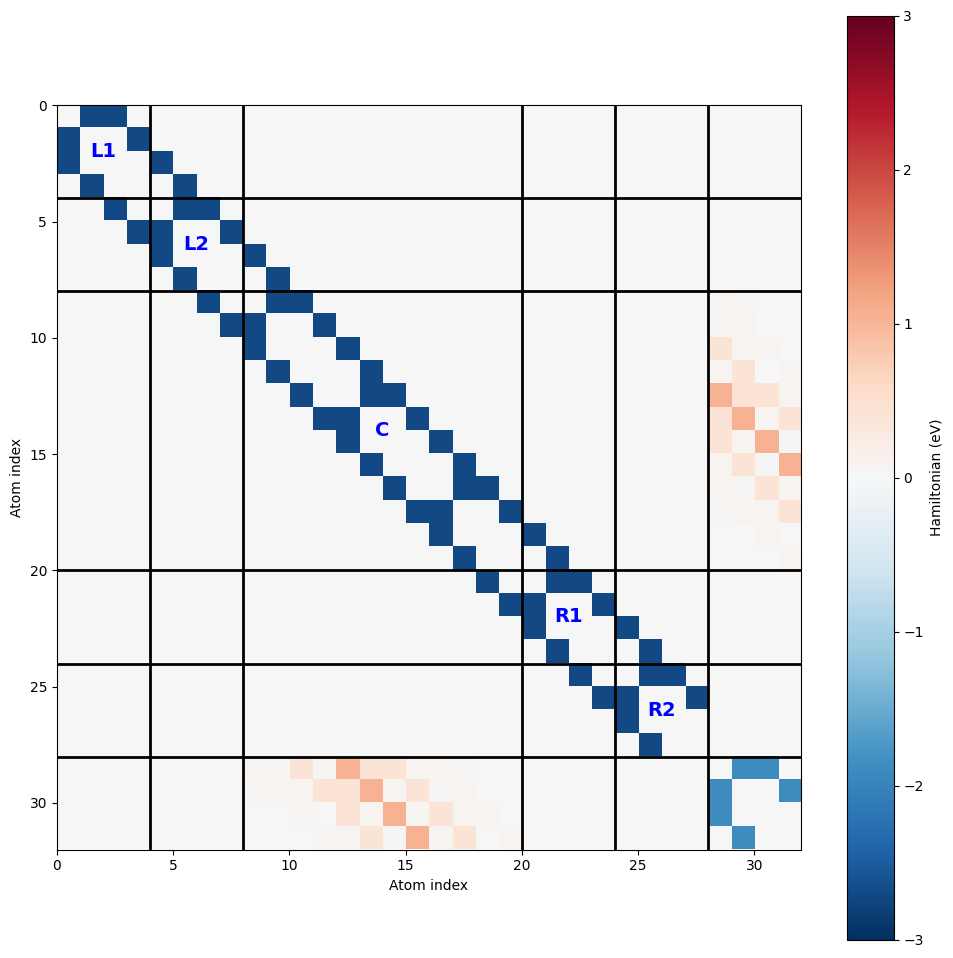

In [108]:
#from functions import slater_koster
H,H_TB,H_SK,_,_= slater_koster(atoms,carbon_only=False)

Hbig = H
nC = len(NR) - 2*nL - 2*nR

# Boundaries
b0 = 0
b1 = nL
b2 = 2*nL
b3 = 2*nL + nC
b4 = 2*nL + nC + nR
b5 = 2*nL + nC + 2*nR #Hbig.shape[0]

plt.figure(figsize=(12,12))
# Use imshow with extent to align indices properly
n = Hbig.shape[0]
plt.imshow(Hbig, extent=(0, n, n, 0), cmap='RdBu_r', vmin=-3, vmax=3)
plt.colorbar(label='Hamiltonian (eV)')

# Draw block boundaries
for b in [b1, b2, b3, b4,b5]:
    plt.axhline(b, color='k', linewidth=2)
    plt.axvline(b, color='k', linewidth=2)

# Add text labels
plt.text((b0+b1)/2, (b0+b1)/2, "L1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b1+b2)/2, (b1+b2)/2, "L2", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b2+b3)/2, (b2+b3)/2, "C", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b3+b4)/2, (b3+b4)/2, "R1", ha='center', va='center', color='b', fontsize=14, weight='bold')
plt.text((b4+b5)/2, (b4+b5)/2, "R2", ha='center', va='center', color='b', fontsize=14, weight='bold')

plt.xlabel('Atom index')
plt.ylabel('Atom index')
plt.show()


In [123]:
H[nL:nL]

array([], shape=(0, 32), dtype=float64)

In [121]:
def SplitHam(H, nL, nR):
    """
    Partition Hamiltonian H with block structure:
    L1 | L2 | C | R1 | R2
    Device D = L2 | C | R1
    """

    no = H.shape[0]
    nC = no - 2*nL - 2*nR
    nD = nL + nC + nR

    if nC < 1:
        print("Setup error: central region size =", nC)
        print("Use [L | L | C | R | R] setup")
        return

    # Boundaries
    b0 = 0
    b1 = nL
    b2 = 2*nL
    b3 = 2*nL + nC
    b4 = 2*nL + nC + nR
    b5 = no

    # Left lead onsite (L1)
    HL = H[b0:b1, b0:b1]

    # L2 → L1 hopping
    VL = H[b1:b2, b0:b1]

    # Coupling L2 ↔ C
    VCL = H[b2:b3, b1:b2]   # C → L2
    VLC = VCL.T.conj()      # L2 → C

    # Central region
    HC = H[b2:b3, b2:b3]

    # Coupling C ↔ R1
    VCR = H[b2:b3, b3:b4]   # C → R1
    VRC = VCR.T.conj()      # R1 → C

    # R1 → R2 hopping
    VR = H[b3:b4, b4:b5]

    # Right lead onsite (R2)
    HR = H[b4:b5, b4:b5]

    # Device block
    HD = H[b1:b4, b1:b4]

    # Lead–device couplings
    VLD = H[b1:b4, b0:b1]   # L1 → device
    VRD = H[b1:b4, b4:b5]   # device → R2

    # Return in left → right order
    return HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD   

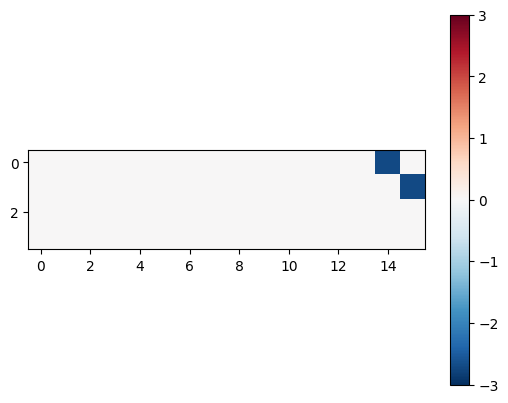

In [120]:
#from functions import SplitHam
HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD =SplitHam(H, nL, nR, nB = len(NR))
plt.imshow(VRC,  cmap='RdBu_r', vmin=-3, vmax=3)
plt.colorbar()

# LDOS

In [111]:
from functions import compute_transmission_caroli

# Calculate spectrum
energies = np.linspace(-10.0, 10.0, 1000)
results_2 = [compute_transmission_caroli(E, 1e-5,HL,VL, HR, VR, HC, VLC, VRC, HD, VLD, VRD,method=2) for E in energies]

# Unpack each column of the results
transmission_2, gl_s_2, gl_b_2, gr_s_2, gr_b_2, g_d_2,sigma_l_2,sigma_r_2 = map(np.array, zip(*results_2))

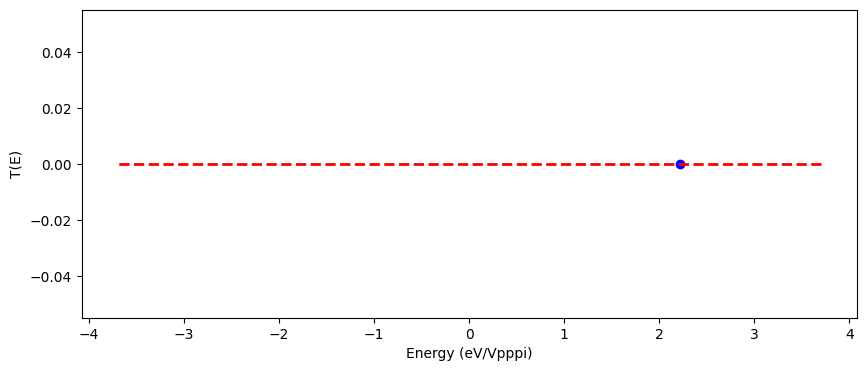

In [99]:
energy_idx = 200 

# --- Plotting ---
plt.figure(figsize=(10, 4))
plt.plot(energies/(-2.7), transmission_2, '--r', lw=2)
plt.scatter(energies[energy_idx]/(-2.7),transmission_2[energy_idx],color = 'b')
plt.xlabel("Energy (eV/Vpppi)")
plt.ylabel("T(E)")
plt.show()

<Figure size 2000x800 with 0 Axes>

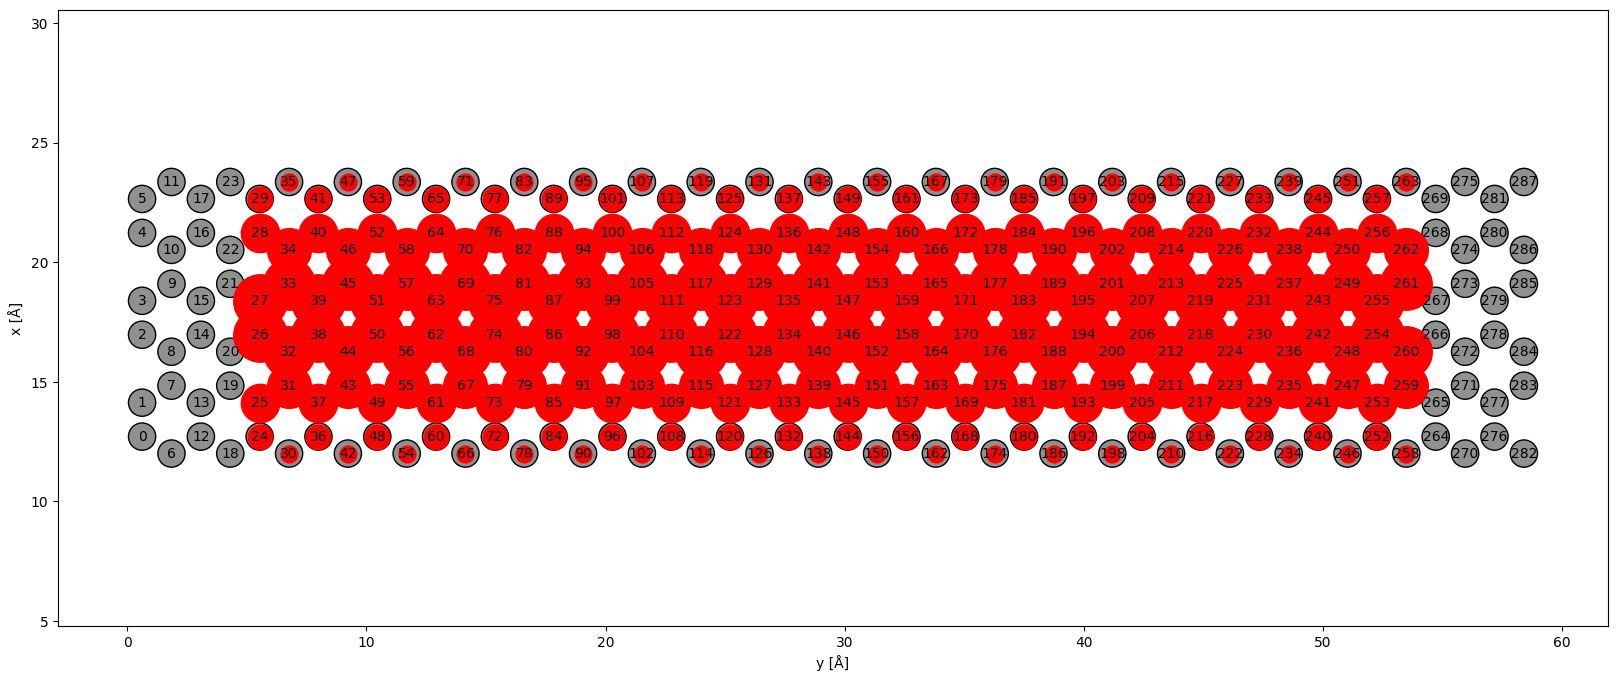

In [105]:

plt.figure(figsize=(20, 8))
abtem.show_atoms(atoms,plane='yx',numbering=True,merge = False,show_cell=False, figsize = (20,8))
for i,idx in enumerate(range(nL*2,nL+nC+nR)): 
    plt.scatter(atoms.positions[idx,1],atoms.positions[idx,0],s=-1000*np.imag(np.diag(g_d_2[105]))[i],c='r')
